In [35]:
import os
#os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

os.environ['TF_USE_LEGACY_KERAS'] = '1';

In [36]:
input_default_json_conf_file='fcnn_emotion4_testing_base_default.json';

In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import json

In [38]:
import sys
sys.path.append('../library');

In [39]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [40]:
## Load json conf json file
fd = open(os.path.join('./',input_default_json_conf_file));
DATA = json.load(fd);
fd.close()

# Variable globales

In [41]:
## Dataset 
dataset_base_test_dir    = DATA['dataset_test_base_dir'];
dataset_labels_test_file = DATA['dataset_test_labels_file'];

dataset_name        = DATA['dataset_name'];

## Model filepath
best_model_file = DATA['model_file'];



## Output
output_base_dir = DATA["output_base_dir"];

NCOD=15;
minus=None;
sub_dir='';
testing_base_name='testing_base';

# Parametros de entrada

In [42]:
for n in range(len(sys.argv)):
    if sys.argv[n]=='--dataset-test-dir':
        dataset_base_test_dir=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-test-file':
        dataset_labels_test_file=sys.argv[n+1];
    elif sys.argv[n]=='--dataset-name':
        dataset_name=sys.argv[n+1];
    elif sys.argv[n]=='--model-file':
        best_model_file=sys.argv[n+1];
    elif sys.argv[n]=='--ncod':
        NCOD=int(sys.argv[n+1]);
    elif sys.argv[n]=='--sub-dir':
        sub_dir=sys.argv[n+1];
    elif sys.argv[n]=='--base-name':
        testing_base_name=sys.argv[n+1];
    elif sys.argv[n]=='--output-dir':
        output_base_dir=sys.argv[n+1];
    elif sys.argv[n]=='--minus':
        minus=int(sys.argv[n+1]);
        
if len(sub_dir)==0:
    if minus is None:
        sub_dir='cls_ncod'+str(NCOD);
    else:
        sub_dir='cls_minus'+str(minus)+'_ncod'+str(NCOD);


print('   dataset_base_test_dir:',dataset_base_test_dir)
print('dataset_labels_test_file:',dataset_labels_test_file)
print('            dataset_name:',dataset_name)
print('                    NCOD:',NCOD)
print('         best_model_file:',best_model_file)
print('                 sub_dir:',sub_dir)
print('       testing_base_name:',testing_base_name)
print('         output_base_dir:',output_base_dir)
print('                   minus:',minus)

        dataset_base_dir: /media/fernando/Expansion/DATASET/TESE/BER/BER2024/BER2024-FUSION/ber2024-source/ncod20_efficientnet_b3_efficientnet_b3_step1
     dataset_labels_file: train.csv
   dataset_base_test_dir: /media/fernando/Expansion/DATASET/TESE/BER/BER2024/BER2024-FUSION/dummy/L30000_p0.15
dataset_labels_test_file: train.csv
   dataset_base_test_dir: /media/fernando/Expansion/DATASET/TESE/BER/BER2024/BER2024-FUSION/ber2024-source/ncod20_efficientnet_b3_efficientnet_b3_step1
dataset_labels_test_file: test.csv
            dataset_name: ber2024-fusion
                  EPOCAS: 100
              BATCH_SIZE: 1024
                    NCOD: 15
                patience: 20
             seed_number: 0
         output_base_dir: /media/fernando/Expansion/OUTPUTS/DOCTORADO2/fcnn_emotion4_fusion_1


# Loading data of dataset

In [44]:
# Load test filenames and labels
test_df = pd.read_csv(os.path.join(dataset_base_test_dir,dataset_labels_test_file));

print('\n\ntest_df')
print(test_df)




dummy_df
             d0        d1        d2        d3        d4        d5        d6  \
0      0.224582  0.133591  0.225396  0.416430  0.115009  0.208645  0.231006   
1      0.037114  0.187126  0.258345  0.517415  0.115193  0.126007  0.259558   
2      0.007186  0.297487  0.224354  0.470973  0.206671  0.182703  0.151418   
3      0.367856  0.171388  0.282665  0.178091  0.521942  0.139584  0.279541   
4      0.276513  0.140360  0.482942  0.100184  0.113897  0.141131  0.465378   
...         ...       ...       ...       ...       ...       ...       ...   
29995  0.208061  0.537792  0.124906  0.129241  0.301961  0.505377  0.119539   
29996  0.275570  0.061500  0.047205  0.615725  0.127590  0.149018  0.243310   
29997  0.398522  0.134628  0.310514  0.156336  0.404484  0.191104  0.205217   
29998  0.023369  0.158488  0.776848  0.041295  0.240887  0.250146  0.278696   
29999  0.189666  0.127528  0.452404  0.230402  0.310355  0.173137  0.388660   

             d7        d8        d9     

# Creating output directory

In [46]:
output_dir = os.path.join(output_base_dir,dataset_name,testing_base_name,sub_dir);

os.makedirs(output_base_dir,exist_ok = True);

os.makedirs(output_dir,exist_ok = True);

# Data augmentation configuration

In [47]:
test_data_array = test_df.iloc[:,:-1].values;
test_y_label = test_df.iloc[:,-1].values;

print(' test:',test_data_array.shape, test_y_label.shape)

train: (51567, 12) (51567,)
  val: (5392, 12) (5392,)
 test: (16658, 12) (16658,)


In [48]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()

test_y       = label_encoder.fit_transform(test_y_label)

test_y_categorical       = to_categorical(test_y)

print(' test:',test_data_array.shape,test_y_categorical.shape)


train: (51567, 12) (51567, 4)
  val: (5392, 12) (5392, 4)
 test: (16658, 12) (16658, 4)


# Create new model

In [49]:
import FusionEmotion4Lib.lib_model as mpp

model = mpp.create_model(  load_weights=False,
                           file_of_weight=best_model_file,
                           ncod=NCOD,
                           minus=minus);

print('input_shape',model.input_shape)
print('output_shape',model.output_shape)
print('')

model.summary()

mpp.save_model_parameters(model, os.path.join(output_dir,'parameters_stats.m'));

input_shape (None, 12)
output_shape (None, 4)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                195       
                                                                 
 dense_1 (Dense)             (None, 4)                 64        
                                                                 
Total params: 259 (1.01 KB)
Trainable params: 259 (1.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-08-09 00:35:40.458887: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-09 00:35:40.459250: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-09 00:35:40.459494: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [50]:
# COMPILE NEW MODEL
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])



In [53]:
data_results=dict();

# Evaluate testing
results = model.evaluate(test_data_array,test_y_categorical)
results = dict(zip(model.metrics_names,results))
print('testing',results,"\n\n");
for key,value in results.items():
    data_results['test_'+key]=value;

data_results['number_of_parameters']=mpp.get_model_parameters(model);
data_results['ncod']=NCOD;

# final all json
with open(os.path.join(output_dir,"testing_data_results.json"), 'w') as f:
    json.dump(data_results, f,indent=4);

tf.keras.backend.clear_session()

1612/1612 [==============================] - 4s 2ms/step - loss: 0.1649 - categorical_accuracy: 0.9905
training {'loss': 0.1648501455783844, 'categorical_accuracy': 0.9904783964157104} 


169/169 [==============================] - 0s 2ms/step - loss: 0.0865 - categorical_accuracy: 0.9776
validation {'loss': 0.08647266030311584, 'categorical_accuracy': 0.9775593280792236} 


521/521 [==============================] - 2s 3ms/step - loss: 0.1264 - categorical_accuracy: 0.9685
testing {'loss': 0.12638325989246368, 'categorical_accuracy': 0.9684836268424988} 




521/521 [==============================] - 1s 2ms/step
Categorical accuracy: 0.9684836114779686
{
    "negative": {
        "precision": 0.9463150459147633,
        "recall": 0.9553125742809603,
        "f1-score": 0.9507925242488763,
        "support": 4207.0
    },
    "neutral": {
        "precision": 0.9622988505747126,
        "recall": 0.9410971223021583,
        "f1-score": 0.9515799045237554,
        "support": 4448.0
    },
    "pain": {
        "precision": 0.9753054989816701,
        "recall": 0.9917162826818535,
        "f1-score": 0.9834424335772045,
        "support": 3863.0
    },
    "positive": {
        "precision": 0.9912896201306557,
        "recall": 0.9896135265700483,
        "f1-score": 0.9904508642572223,
        "support": 4140.0
    },
    "accuracy": 0.9684836114779686,
    "macro avg": {
        "precision": 0.9688022539004505,
        "recall": 0.969434876458755,
        "f1-score": 0.9690664316517646,
        "support": 16658.0
    },
    "weighted avg": 

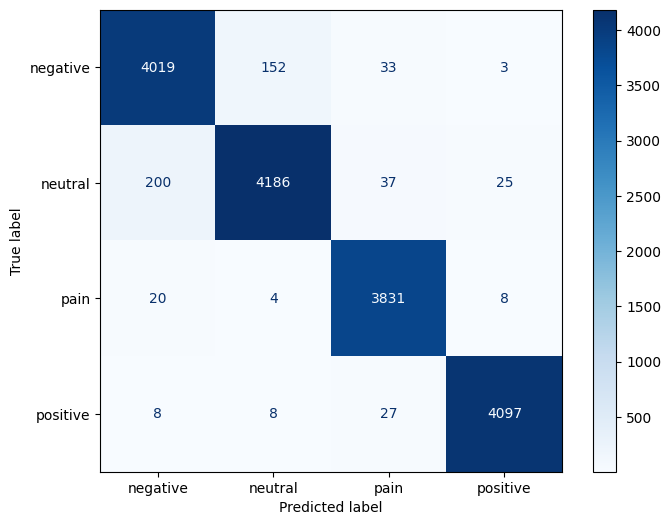

In [54]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

target_names = ['negative','neutral','pain','positive'];

# Predict
Y_pred = model.predict(test_data_array,verbose=1);
y_pred = np.argmax(Y_pred, axis=1);

# Calculate accuracy
categorical_accuracy = np.mean(test_y == y_pred);
print(f'Categorical accuracy: {categorical_accuracy}');

# Confusion matrix
CM=confusion_matrix(test_y, y_pred);

fname=os.path.join(output_dir,"confusion_matrix.eps");
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=target_names)
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.savefig(fname)

cm_dict=dict();
cm_dict['matrix']=CM.tolist();
cm_dict['label']=target_names;
# final all json
with open(os.path.join(output_dir,"confusion_matrix.json"), 'w') as f:
    json.dump(cm_dict, f,indent=4);
    f.close()

# Classification report
fname=os.path.join(output_dir,"classification_report.json")
dict_dat=classification_report(test_y, y_pred, target_names=target_names,output_dict=True);
print(json.dumps(dict_dat, indent=4))
with open(fname, 'w') as f: 
    json.dump(dict_dat, f,indent=4);
    f.close()